In [1]:
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [2]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def create_chainplot(inchain):

    fig, ax = plt.subplots()
    draw_chains(fig, ax, inchain)
    
    return fig, ax

def update_chainplot(fig, ax, inchain):
    
    ax.cla()
    draw_chains(fig, ax, inchain)

    fig.canvas.draw()
    fig.canvas.flush_events()

    return

def draw_chains(fig, ax, inchain):

    ax.set_aspect('equal', 'box')
    ax.set(xlim=(-7, 7),ylim=(-7, 7))
    circles = list()
    for ibead in range(chain.Nbeads):
        circles.append(mpatches.Circle(chain.rpos[ibead],radius=chain.R))

    for circle in circles:
        ax.add_patch(circle)
    
    xpoints = chain.rpos[:,0]
    ypoints = chain.rpos[:,1]
    ax.plot(xpoints,ypoints)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Current polymer configuration")
    
    return

In [3]:
def run_mcmc_sweeps(chain, Nsweeps=100, max_disp=0.15, temperature=0.2, sample_int=100):
    """Summary or Description of the Function

    Parameters:
    argument1 (int): Description of arg1

    Returns:
    int:Returning value

   """

    beta = 1.0/temperature # Store inverse temperature

    samples = [] # Initialise samples for the current set of sweeps
    acount  = 0  # Number of accepted moves

    # Each sweep is one trial per bead on average
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1,chain.Nbeads)

        # Generate random displacement
        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        # Make trial move and compute energy change
        old_local_energy = chain.local_energy(ibead)
        chain.rpos[ibead] = chain.rpos[ibead] + disp
        new_local_energy = chain.local_energy(ibead)
        diff_energy = new_local_energy - old_local_energy

        # Accept or reject move
        if np.random.sample() < m.exp(-diff_energy*beta):
            acount = acount + 1 # Accepted - increment counter
        else:
            # Restore original chain position 
            chain.rpos[ibead] = chain.rpos[ibead] - disp

        # Sample energy and end-to-end distance every sample_int sweeps
        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

    ratio = acount/(Nsweeps*(chain.Nbeads-1)) 
    
    # Return current chain, list of samples and acceptance ration
    return chain, samples, ratio

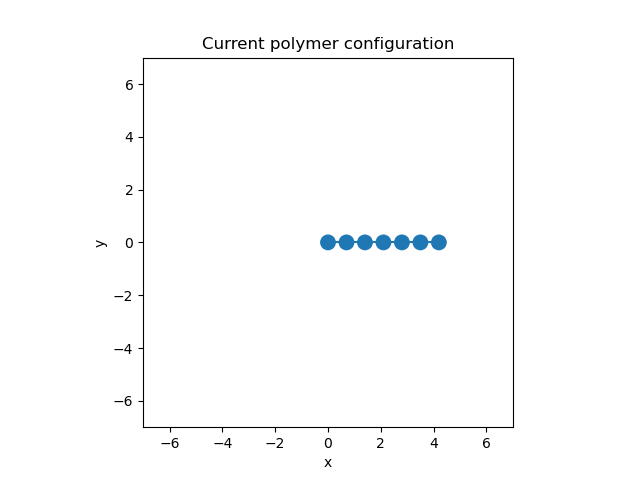

In [4]:
# Create polymer chain
Ndims = 2 ; Nbeads = 7
chain = polymer(Ndims, Nbeads)

# Define bins to be used for plotting
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Visualise the initial state of the chain
%matplotlib widget
fig, ax = create_chainplot(chain)
plt.show();

In [65]:
from ipywidgets import IntProgress
from IPython.display import display

temp = 0.4
Nframes = 1000

f = IntProgress(min=0, max=Nframes) # instantiate the bar
samples = []

display(f) # display the bar

for iframe in range(Nframes):

    chain, new_samples, ratio = run_mcmc_sweeps(chain, max_disp=0.1, temperature=temp)
    samples += new_samples
    update_chainplot(fig, ax, chain)
    f.value +=1  # Increment progress bar


print("Accepted ",round(ratio*100,2),"% of trial moves")

# Save samples to file
filename = "mcmc_N"+str(Nbeads)+"_d"+str(Ndims)+"_T{:1.3}".format(temp)+"_Nf"+str(Nframes)+".npy"
np.save(filename,np.asarray(samples))
print("Written samples to : ",filename)

IntProgress(value=0, max=1000)

Accepted  54.17 % of trial moves
Written samples to :  mcmc_N7_d2_T0.4_Nf1000.npy


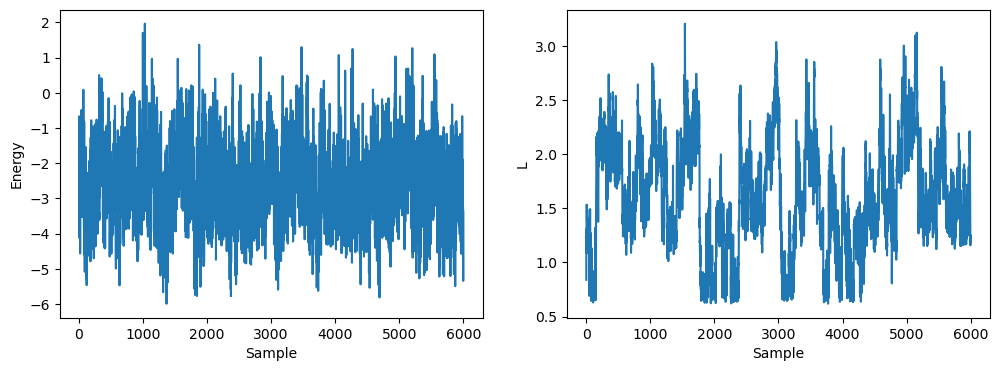

In [49]:
%matplotlib inline
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(energy_samples)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Energy")
ax2.plot(end2end_samples);
ax2.set_xlabel("Sample")
ax2.set_ylabel("L");

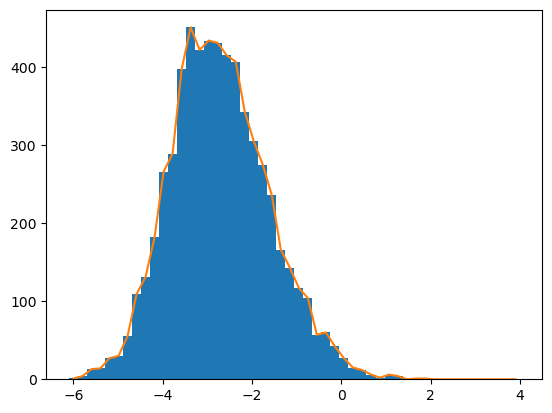

In [50]:
counts, bins = np.histogram(energy_samples,bins=bin_edges)
plt.hist(bins[:-1], bins, weights=counts)
#plt.bar(bins[:-1],counts,width=bin_width,align='edge')
plt.plot(bins[:-1]+0.5*bin_width,counts)
#counts, bins = np.histogram(end2end_samples,bins=20)
#plt.hist(bins[:-1], bins, weights=counts)

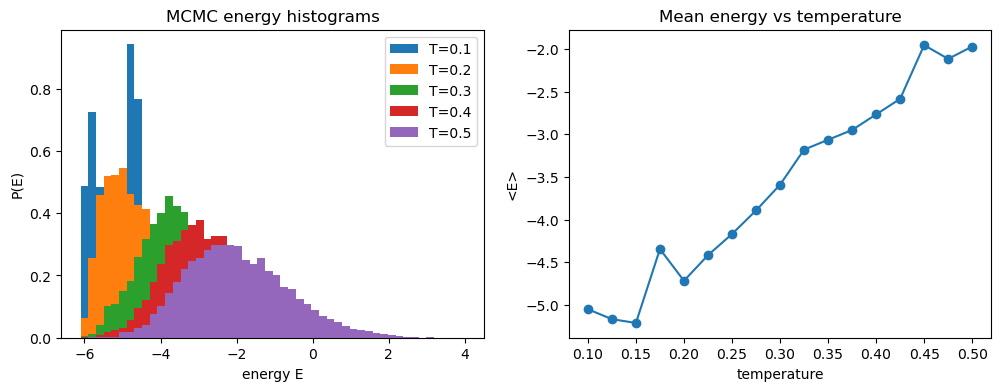

In [97]:
# Get results from a longer run I did earler from file
temperatures = np.arange(0.1, 0.6, 0.1)
#temperatures = [0.4]

fix, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

for temperature in temperatures:
    
    filename = "mcmc_N7_d2_T{:1.3}_Nf1000.npy".format(temperature)

    samples = np.load(filename).tolist()
    energy_samples  = [ sample[0] for sample in samples ]
    #end2end_samples = [ sample[1] for sample in samples ]

    counts, bins = np.histogram(energy_samples, bins=bin_edges, density=True)
    strlabel = "T={:1.1}".format(temperature)
    ax1.bar(bins[:-1], counts, width=bin_width, align='edge', label=strlabel)
    #ax1.plot(bins[:-1], counts, '-o', label=strlabel)

ax1.set_xlabel('energy E')
ax1.set_ylabel('P(E)')
ax1.set_title("MCMC energy histograms")
ax1.legend()

temperatures = np.arange(0.1, 0.525, 0.025)
#temperatures = [0.4]

mean_energies = np.zeros(len(temperatures))
mean_errors   = np.zeros(len(temperatures))

for itemp, temperature in enumerate(temperatures):
    
    filename = "mcmc_N7_d2_T{:1.3}_Nf1000.npy".format(temperature)

    samples = np.load(filename).tolist()
    energy_samples  = [ sample[0] for sample in samples ]
    #energy_samples  = [ sample[0] for sample in samples[1000:6000:100] ] # Drop equilibration period and subsample

    mean_energies[itemp] = np.mean(energy_samples)
    mean_errors[itemp] = np.std(energy_samples)/m.sqrt(len(energy_samples))
    
ax2.errorbar(temperatures, mean_energies,yerr=mean_errors, fmt='-o')
ax2.set_xlabel('temperature')
ax2.set_ylabel('<E>')
ax2.set_title('Mean energy vs temperature')  
plt.show()





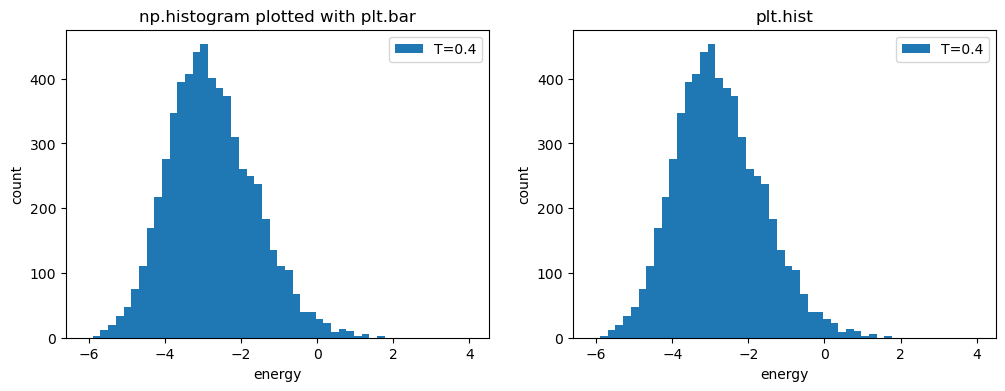

In [53]:
# Sanity checking two equivalent ways of generating the same histogram
samples = np.load("mcmc_N7_d2_T0.4_Nf1000.npy").tolist()
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

# Use np.histogram and then plt.bar with the output
counts, bins = np.histogram(energy_samples, bins=bin_edges)
ax1.bar(bins[:-1], counts, width=bin_width, align='edge', label='T=0.4')
ax1.set_xlabel('energy')
ax1.set_ylabel('count')
ax1.set_title("np.histogram plotted with plt.bar")
ax1.legend()

# Use plt.hist
n, bins, patches = ax2.hist(bins[:-1], bins, weights=counts, label='T=0.4')
ax2.set_xlabel('energy')
ax2.set_ylabel('count')
ax2.set_title("plt.hist")
ax2.legend()
plt.show()